In [37]:
# Remved warnings 
import warnings  
warnings.filterwarnings('ignore')

# This packages are used for file handling
import os
import os.path
import random 
import pickle 
from tqdm import tqdm
from datetime import datetime

# Used for plotting and visualizations
%matplotlib inline 
import seaborn as sns 
import matplotlib.pyplot as plt 

# For linear algebra and arrays manipulation 
import cv2 
import math
import random 
import pandas as pd
import numpy as np
from numpy import save, load, asarray


# Building machine learning model 
import keras
import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto, InteractiveSession
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import losses
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import mobilenet_v2, mobilenet, densenet
from tensorflow.keras.layers import (Dense, MaxPooling2D, Conv2D, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D, MaxPool2D,
    DepthwiseConv2D, Dropout, ReLU, Concatenate, DepthwiseConv2D, Input, add,  Conv2DTranspose)


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
# Config variables
from config import * 
from resnet_model import  * 

In [38]:
# Initialize CUDA
config = ConfigProto()

config.gpu_options.per_process_gpu_memory_fraction = 2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [39]:
# Initialize WANDB dashboard 
import wandb
from wandb.keras import WandbCallback

os.environ["WANDB_NOTEBOOK_NAME"] = "main.ipynb"
os.environ["WANDB_API_KEY"] = '2257bf21347391d8f93c8f9f7d620cbbfbf9dcc5'
wandb.login()
wandb.init(project="VGG-16 model", entity="coder-ph")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [40]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='constant'
)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    'data/training',
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical'
)
validation_dataget = ImageDataGenerator(rescale=1./255)
validation_generator = train_datagen.flow_from_directory(
    'data/testing',
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical'
)

Found 30401 images belonging to 9 classes.
Found 14857 images belonging to 9 classes.


In [47]:
EPOCHS=100
LEARNING_RATE = 0.001
DECAY_RATE = LEARNING_RATE/EPOCHS
MOMENTUM =  0.8	


# Initalize Callbacks 
#ModelCheckpoint callback saves a model at some interval. 
filepath="saved_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.ckpt" #File name includes epoch and validation accuracy.

	#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=11, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('nihogalog_logs_vgg16.csv', separator=',', append=False)

#######################################################################
#CUSTOM LEARNING RATE
#Time based decay: lr *= (1. / (1. + decay * iterations))

#Step decay drops the learning rate by a factor every few epochs.: 
# lr = lr0 * drop^floor(epoch / epochs_drop) 
#import math
#def step_decay(epoch):
#   initial_lrate = 0.1
#   drop = 0.5
#   epochs_drop = 10.0
#   lrate = initial_lrate * math.pow(drop,  
#           math.floor((1+epoch)/epochs_drop))
#   return lrate


#Eexponential decay
#To be used instead of static learning rate of 0.1
# 𝑙𝑟=𝑙𝑟₀ × 𝑒**(−𝑘𝑡)
#lr can still be used as initial value. 


#NOTE: Redefine model with a new name to make sure we start from scratch

def exp_decay(epoch):
    lrate = LEARNING_RATE  * np.exp(-DECAY_RATE*EPOCHS)
    return lrate
lr_rate = LearningRateScheduler(exp_decay,verbose=0)



callbacks = [
    checkpoint, 
    early_stop, 
    log_csv,
    lr_rate,
    WandbCallback(dataset_name="Resnet")
]

In [48]:


def VGG16(shape, classes):
    # input

    input = Input(shape =shape)
    # 1st Conv Block

    x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(input)
    x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    x = Dropout(0.2)(x)
    # 2nd Conv Block

    x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    x = Dropout(0.2)(x)
    # 3rd Conv block

    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    x = Dropout(0.2)(x)
    # 4th Conv block

    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    x = Dropout(0.2)(x)
    # 5th Conv block

    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    x = Dropout(0.2)(x)
    # Fully connected layers

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(units = 4096, activation ='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units = 4096, activation ='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(units = classes, activation ='softmax')(x)
    # creating the model

    model = Model (inputs=input, outputs =output)

    return model

model = VGG16(shape=INPUT_SHAPE, classes=len(CATEGORIES))
sgd = tf.keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM, decay=DECAY_RATE, nesterov=False)
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=sgd,
    metrics=['accuracy'],
)

history = model.fit( train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/100
951/951 [==============================] - ETA: 0s - loss: 2.1943 - accuracy: 0.1310
Epoch 1: val_accuracy improved from -inf to 0.13145, saving model to saved_models\weights-improvement-01-0.13.ckpt
INFO:tensorflow:Assets written to: saved_models\weights-improvement-01-0.13.ckpt\assets
951/951 [==============================] - 85s 88ms/step - loss: 2.1943 - accuracy: 0.1310 - val_loss: 2.1927 - val_accuracy: 0.1315 - lr: 9.9900e-04 - _timestamp: 1648877489.0000 - _runtime: 761.0000
Epoch 2/100
951/951 [==============================] - ETA: 0s - loss: 2.1922 - accuracy: 0.1319
Epoch 2: val_accuracy did not improve from 0.13145
951/951 [==============================] - 81s 85ms/step - loss: 2.1922 - accuracy: 0.1319 - val_loss: 2.1919 - val_accuracy: 0.1315 - lr: 9.9900e-04 - _timestamp: 1648877570.0000 - _runtime: 842.0000
Epoch 3/100
951/951 [==============================] - ETA: 0s - loss: 2.1911 - accuracy: 0.1319
Epoch 3: val_accuracy did not improve from 0.13145
95

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr', '_timestamp', '_runtime'])

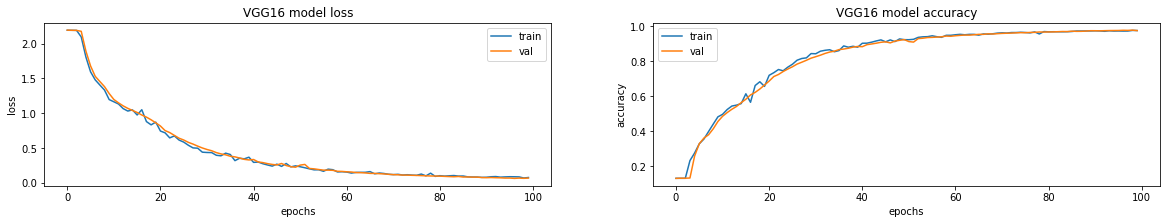

In [50]:

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['loss', 'accuracy']):
    ax[i].plot(history.history['val_'+met])
    ax[i].plot(history.history[met])
    ax[i].set_title('VGG16 model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
history.history.keys()

In [52]:
model.save('save-models/vgg16')

INFO:tensorflow:Assets written to: save-models/vgg16\assets


In [53]:
model = tf.keras.models.load_model('save-models/vgg16')
X, y = [],[]
total_images = validation_generator.n  
steps = total_images//32
for i in range(steps):
    X_gen,y_gen = validation_generator.next()
    X.extend(X_gen)
    y.extend(y_gen )
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((14825, 50, 50, 3), (14825, 9))

(14825, 50, 50, 3)
465/465 [==============================] - 13s 28ms/step - loss: 0.3089 - accuracy: 0.9114
loss: 0.3089463412761688
acc: 0.9113548994064331


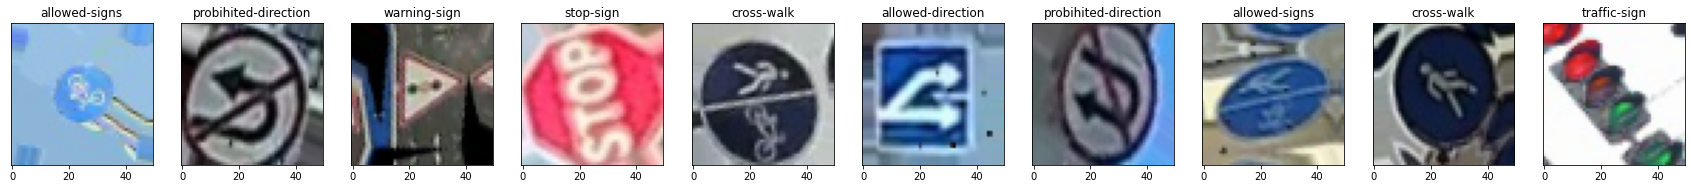

In [55]:

a = X[:10]
preds = model.predict(X[:10])
true_label = np.array([np.argmax(i) for i in preds])

print(X.shape)
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(30,4))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(a[i])
    plt.title(f'{CATEGORIES[true_label[i]]}')
    plt.xticks()
    plt.yticks([])
eval = model.evaluate(validation_generator)
print(f'loss: {eval[0]}')
print(f'acc: {eval[1]}')


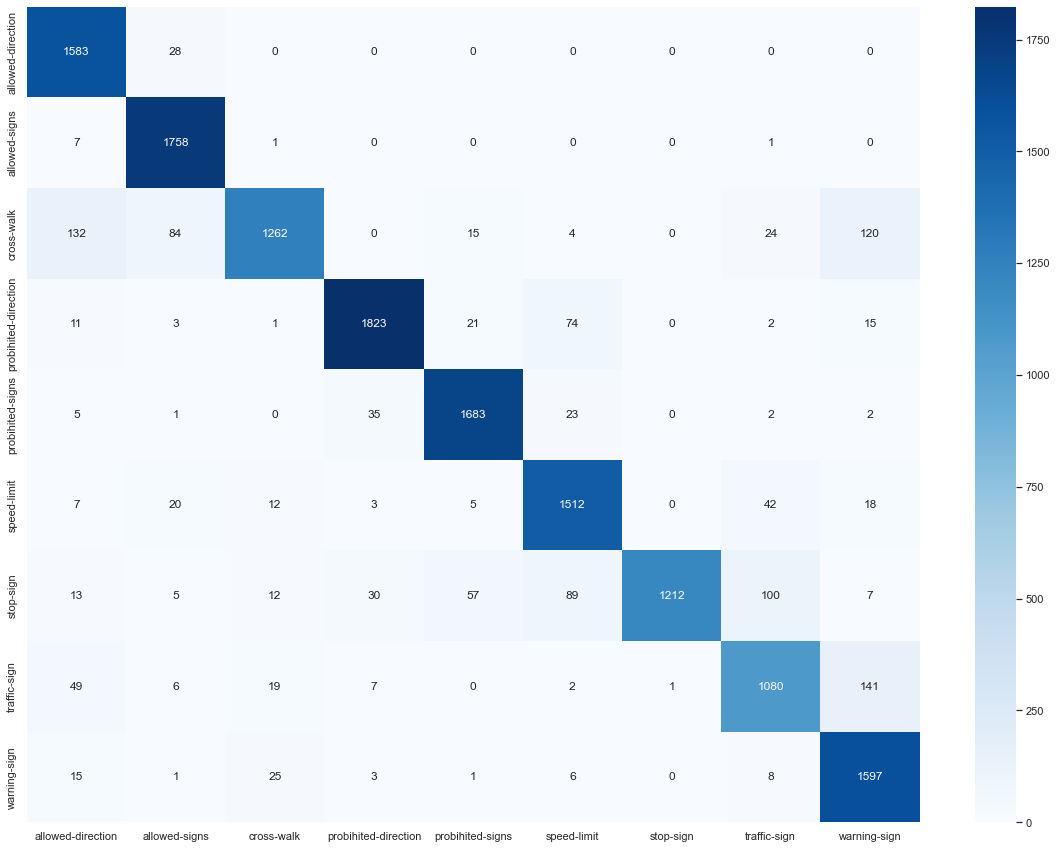

In [57]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns


actual_y = [ np.argmax(i) for i in y]
preds_y =  [ np.argmax(i) for i in model.predict(X)] 
conf_mat = confusion_matrix(actual_y , preds_y)

# sns.set( font_scale=1.5)
plt.figure(figsize=(20,15))
df_cm = pd.DataFrame(conf_mat, CATEGORIES,  CATEGORIES)
sns.set(font_scale=1) # for label size
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax = sns.heatmap(df_cm , annot=True, cmap='Blues', fmt='g')
# print(conf_mat)


In [58]:
from sklearn.metrics import classification_report
print(classification_report(actual_y , preds_y, target_names=CATEGORIES))

                      precision    recall  f1-score   support

   allowed-direction       0.87      0.98      0.92      1611
       allowed-signs       0.92      0.99      0.96      1767
          cross-walk       0.95      0.77      0.85      1641
probihited-direction       0.96      0.93      0.95      1950
    probihited-signs       0.94      0.96      0.95      1751
         speed-limit       0.88      0.93      0.91      1619
           stop-sign       1.00      0.79      0.89      1525
        traffic-sign       0.86      0.83      0.84      1305
        warning-sign       0.84      0.96      0.90      1656

            accuracy                           0.91     14825
           macro avg       0.91      0.91      0.91     14825
        weighted avg       0.92      0.91      0.91     14825

